In [ ]:
import sys
import os

# Add the parent directory (project root) to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Randomness

## JAX

In [ ]:
from general_python.algebra.utils import get_backend as __backend
from general_python.algebra.ran_wrapper import uniform, randint
# test random
seed    = None
backend = 'np'
for i in range(5):
    modules = __backend(backend, random=True, seed=seed)
    backend, (rnd_module, key) = modules if isinstance(modules, tuple) else (modules, (None, None))
    print(f"backend: {backend}")
    print(f"key: {key}")
    print(f"rnd_module: {rnd_module}")
    print(f"rnd_module.random(): {rnd_module.random()}")
    print(f"rnd_module.randint(0, 10): {rnd_module.integers(0, 10)}")
    print(f"rnd_module.uniform(0, 10): {rnd_module.uniform(0, 10)}")
    print(f"rnd_module.normal(0, 1): {rnd_module.normal(0, 1)}")
    # take the function from random wrapper
    print(f"uniform(0, 10): {uniform(shape=(5,),minval=0, maxval=10, backend=backend, seed=seed)}")
    print()

# Models
This set of 

## Operators Test with all backends

In [ ]:
from general_python.lattices.honeycomb import HoneycombLattice
from general_python.lattices.lattice import LatticeBC
import general_python.common.binary as bin_mod
import numpy as np

backend = 'np'
lat     = HoneycombLattice( dim     = 2,
                            lx      = 2,
                            ly      = 2,
                            lz      = 1,
                            bc      = LatticeBC.PBC)
lat

### Local operators test

In [ ]:
# create an operator
import Algebra.Operator.operators_spin as op_spin
import jax.numpy as jnp

sig_x = op_spin.sig_x(
    lattice  = lat,
    type_act = op_spin.OperatorTypeActing.Local
)
sig_z = op_spin.sig_z(
    lattice  = lat,
    type_act = op_spin.OperatorTypeActing.Local
)

# create a set of states and test it
int_state = np.random.randint(0, 2**lat.ns, dtype=np.int32)
np_state  = np.ones((lat.ns), dtype = np.float64)
jnp_state = jnp.ones((lat.ns), dtype = jnp.float64)

int_state, np_state, jnp_state

#### Integer states

In [ ]:
print(f"Before: {bin_mod.int2binstr(int_state, lat.ns)}")
for i in range(lat.ns):
    print(f"i: {i})")
    print("\tSigma Z")
    # sig_z
    int_state_mod, int_state_mod_val = sig_z(int_state, i)
    print(f"\t\tAfter {i}'th s_z: ({int_state_mod[0]})b{bin_mod.int2binstr(int_state_mod[0], lat.ns)} with value {int_state_mod_val}")
    print("\tSigma X")
    # sig_x
    int_state_mod, int_state_mod_val = sig_x(int_state, i)
    print(f"\t\tAfter {i}'th s_x: ({int_state_mod[0]})b{bin_mod.int2binstr(int_state_mod[0], lat.ns)} with value {int_state_mod_val}")

#### Numpy states

In [ ]:
for i in range(lat.ns):
    print(f"i: {i})")
    sites            = [i]
    np_modified_x, _ = sig_x(np_state, *sites)
    np_modified_z, _ = sig_z(np_state, *sites)
    print(f"Before: {np_state}, acting on sites {sites}")
    print(f"After X: {np_modified_x}")
    print(f"After Z: {np_modified_z}")

#### Jax states

In [ ]:
for i in range(lat.ns):
    print(f"i: {i})")
    sites            = [i]
    jnp_modified_x, _ = sig_x(jnp_state.copy(), sites[0])
    jnp_modified_z, _ = sig_z(jnp_state.copy(), sites[0])
    print(f"Before: {jnp_state}, acting on sites {sites}")
    print(f"After X: {jnp_modified_x}")
    print(f"After Z: {jnp_modified_z}")

### Correlation

In [ ]:
# create an operator
import Algebra.Operator.operators_spin as op_spin
import jax.numpy as jnp

sig_x = op_spin.sig_x(
    lattice  = lat,
    type_act = op_spin.OperatorTypeActing.Correlation
)
sig_z = op_spin.sig_z(
    lattice  = lat,
    type_act = op_spin.OperatorTypeActing.Correlation
)

# create a set of states and test it
int_state = np.random.randint(0, 2**lat.ns, dtype=np.int32)
np_state  = np.ones((lat.ns), dtype = np.float64)
jnp_state = jnp.ones((lat.ns), dtype = jnp.float64)

int_state, np_state, jnp_state

#### Integer states

In [ ]:
print(f"Before: {bin_mod.int2binstr(int_state, lat.ns)}")
for i in range(lat.ns):
    sites = [i, (i+1)%lat.ns]
    print(f"i: {i})")
    print("\tSigma Z")
    # sig_z
    int_state_mod, int_state_mod_val = sig_z(int_state, *sites)
    print(f"\t\tAfter {sites}'th s_z: ({int_state_mod[0]})b{bin_mod.int2binstr(int_state_mod[0], lat.ns)} with value {int_state_mod_val}")
    print("\tSigma X")
    # sig_x
    sites = [i, (i+1)%lat.ns]
    int_state_mod, int_state_mod_val = sig_x(int_state, *sites)
    print(f"\t\tAfter {sites}'th s_x: ({int_state_mod[0]})b{bin_mod.int2binstr(int_state_mod[0], lat.ns)} with value {int_state_mod_val}")

#### Numpy states

In [ ]:
for i in range(lat.ns):
    print(i)
    sites            = [i, (i+1)%lat.ns]
    np_modified_x, _ = sig_x(np_state.copy(), *sites)
    np_modified_z, _ = sig_z(np_state.copy(), *sites)
    print(f"Before: {np_state}, acting on sites {sites}")
    print(f"After X: {np_modified_x}")
    print(f"After Z: {np_modified_z}")

#### JAX states

In [ ]:
for i in range(lat.ns):
    print(i)
    sites            = [i, (i+1)%lat.ns]
    jnp_modified_x, _ = sig_x(jnp_state.copy(), *sites)
    jnp_modified_z, _ = sig_z(jnp_state.copy(), *sites)
    print(f"Before: {jnp_state}, acting on sites {sites}")
    print(f"After X: {jnp_modified_x}")
    print(f"After Z: {jnp_modified_z}")

### Globals

In [ ]:
# create an operator
import Algebra.Operator.operators_spin as op_spin
import jax.numpy as jnp
sites = [0, 2]
sig_x = op_spin.sig_x(
    lattice  = lat,
    sites    = sites
)
sig_z = op_spin.sig_z(
    lattice  = lat,
    sites    = sites
)

# create a set of states and test it
int_state = np.random.randint(0, 2**lat.ns, dtype=np.int32)
np_state  = np.ones((lat.ns), dtype = np.float64)
jnp_state = jnp.ones((lat.ns), dtype = jnp.float64)

int_state, np_state, jnp_state

#### Integer states

In [ ]:
int_modified_x, _ = sig_x(int_state)
int_modified_z, _ = sig_z(int_state)
print(f"Before: {bin_mod.int2binstr(int_state, lat.ns)}, acting on sites {sites}")
print(f"After X: {bin_mod.int2binstr(int_modified_x[0], lat.ns)}")
print(f"After Z: {bin_mod.int2binstr(int_modified_z[0], lat.ns)}")

#### Numpy

In [ ]:
np_modified_x, _ = sig_x(np_state.copy())
np_modified_z, _ = sig_z(np_state.copy())
print(f"Before: {np_state}, acting on sites {sites}")
print(f"After X: {np_modified_x}")
print(f"After Z: {np_modified_z}")

#### JNP

In [ ]:
jnp_modified_x, _ = sig_x(jnp_state.copy())
jnp_modified_z, _ = sig_z(jnp_state.copy())
print(f"Before: {jnp_state}, acting on sites {sites}")
print(f"After X: {jnp_modified_x}")
print(f"After Z: {jnp_modified_z}")

## Any Hamiltonian defined from the operators

Underneath, the Hamiltonian is constructed using the defined operators, such as `sig_x` and `sig_z`, which act on specific sites or globally on the lattice. These operators are combined with appropriate multipliers to represent the physical interactions in the system. The Hamiltonian is then built, diagonalized, and used to compute eigenvalues, eigenvectors, and other properties of the quantum system.


In [ ]:
import numpy as np
import Algebra.hamil as hamil
from Algebra.Operator.operator import  test_operators
from general_python.lattices.honeycomb import HoneycombLattice
from general_python.lattices.lattice import LatticeBC

backend = 'np'
lat     = HoneycombLattice( dim     = 2,
                            lx      = 2,
                            ly      = 2,
                            lz      = 1,
                            bc      = LatticeBC.PBC)
ham     = hamil.Hamiltonian(
    hilbert_space   = None,
    is_sparse       = True,
    dtype           = np.float64,
    lattice         = lat,
    backend         = backend,
)
print(lat)
print()
# create a set of states and test it
(int_state, np_state, jnp_state), operators = hamil.test_generic_hamiltonian(ham=ham, ns=lat.ns)
sig_x, sig_z, sig_z_0, sig_x_2, sig_z_sig_z, sig_z_loc, sig_x_loc, sig_z_cor = operators
print(f"int_state: {int_state}")
print(f"np_state: {np_state}")
print(f"jnp_state: {jnp_state}")

# reset the Hamiltonian operators
ham.reset_operators()

# add operators to the Hamiltonian
ham.add(
    operator    = sig_x,
    multiplier  = 1.0,
    sites       = None,
    # modifies    = True
)

ham.add(
    operator    = sig_z,
    multiplier  = 0.5,
    sites       = None,
    # modifies    = False
)

# add some local s_z
ham.add(
    operator    = sig_z_loc,
    multiplier  = -5.0,
    sites       = [5],
    # modifies    = False
)

# add some local s_x
ham.add(
    operator    = sig_x_loc,
    multiplier  = -5.0,
    sites       = [4],
    # modifies    = True
)

ham._set_local_energy_functions()

### Integer states

##### $\sigma _x^0 \sigma_x^2 |\psi ^{\rm int}\rangle$

In [ ]:
out = test_operators(sig_x, int_state, ns = lat.ns, output_format='tabs')

##### $\sigma _z^0 \sigma_z^2 |\psi ^{\rm int}\rangle$

In [ ]:
out = test_operators(sig_z, int_state, ns = lat.ns, output_format='tabs')

##### $2 * \sigma _x^0 \sigma_x^2 |\psi ^{\rm int}\rangle$

In [ ]:
out = test_operators(sig_x_2, int_state, ns = lat.ns, output_format='tabs')

##### $\sigma _z (i) |\psi ^{\rm int}\rangle$

In [ ]:
out = test_operators(sig_z_loc, int_state, ns = lat.ns, output_format='tabs', add_args=(5,))

##### $\sigma _z^0  (\sigma _z^0 \sigma_x^2) |\psi ^{\rm int}\rangle$

In [ ]:
# %timeit -r 5 -n 20 sig_z_sig_z(int_state)
sig_z_sig_z(int_state)

##### $H |\psi ^{\rm int} \rangle $

In [ ]:
%%timeit -r 5 -n 20
for i in range(lat.ns):
    ham.loc_energy(k = int_state, i = i)

In [ ]:
for i in range(lat.ns):
    print(ham.loc_energy(k = int_state, i = i))

### Numpy states

##### $\sigma _x^0 \sigma_x^2 |\psi ^{\rm np}\rangle$

In [ ]:
out = test_operators(sig_x, np_state, ns = lat.ns, output_format='tabs')

##### $\sigma _z^0 \sigma_z^2 |\psi ^{\rm np}\rangle$

In [ ]:
out = test_operators(sig_z, np_state, ns = lat.ns, output_format='tabs')

##### $2 * \sigma _x^0 \sigma_x^2 |\psi ^{\rm np}\rangle$

In [ ]:
out = test_operators(sig_x_2, np_state, ns = lat.ns, output_format='tabs')

##### $H |\psi ^{\rm np} \rangle $

In [ ]:
%timeit -r 5 -n 5 ham.loc_energy(k = np_state)
ham.loc_energy(k = np_state)

### JAX states

##### $\sigma _x^0 \sigma_x^2 |\psi ^{\rm jax}\rangle$

In [ ]:
out = test_operators(sig_x, jnp_state, ns = lat.ns, output_format='tabs')

##### $\sigma _z^0 \sigma_z^2 |\psi ^{\rm jax}\rangle$

In [ ]:
out = test_operators(sig_z, jnp_state, ns = lat.ns, output_format='tabs')

##### $2 * \sigma _x^0 \sigma_x^2 |\psi ^{\rm jax}\rangle$

In [ ]:
out = test_operators(sig_x_2, jnp_state, ns = lat.ns, output_format='tabs')

##### $H |\psi ^{\rm jax} \rangle $

In [ ]:
%timeit -r 5 -n 5 result = ham.loc_energy(k=jnp_state)
ham.loc_energy(k=jnp_state)

### Build matrix

In [ ]:
ham.build(verbose=True, use_numpy=True)

In [ ]:
ham.diagonalize(verbose=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ham.eig_val)
ham.eig_val, ham.eig_vec, ham.eig_vec.shape

## Heisenberg - Kitaev model

In [ ]:
from Algebra.Model.Interacting.Spin.heisenberg_kitaev import HeisenbergKitaev, HEI_KIT_Z_BOND_NEI, HEI_KIT_X_BOND_NEI, HEI_KIT_Y_BOND_NEI
from general_python.lattices.honeycomb import HoneycombLattice
from general_python.lattices.lattice import LatticeBC

backend = 'np'
lat     = HoneycombLattice( dim     = 2,
                            lx      = 2,
                            ly      = 2,
                            lz      = 1,
                            bc      = LatticeBC.PBC)
lat

#### Printout the neighbors

In [ ]:
# for i in range(lat.ns):
#     print(f"site {i}:")
#     n_nei = lat.get_nn_forward_num(i)
#     print(f"\tn_nei:{n_nei}")
    
#     for j in range(n_nei):
#         nei = lat.get_nn_forward(i, j)
#         print(f"\t\tnei {j}:\t{nei}", end='')
#         if j == HEI_KIT_Z_BOND_NEI:
#             print(f"\t\t\tbond Z")
#         elif j == HEI_KIT_Y_BOND_NEI:
#             print(f"\t\t\tbond Y")
#         elif j == HEI_KIT_X_BOND_NEI:
#             print(f"\t\t\tbond X")

#### GO!

In [ ]:
hx      = 0.5
hz      = -0.3
j       = 1.0
kx      = 1.0
ky      = 1.0
kz      = 1.0
dlt     = 1.0

hamil   = HeisenbergKitaev(lattice      = lat, 
                        hilbert_space   = None, 
                        hx              = hx,
                        hz              = hz,
                        kx              = kx,
                        ky              = ky,
                        kz              = kz,
                        j               = j,
                        dlt             = dlt, 
                        dtype           = float,
                        backend         = backend)

In [ ]:
hamil.build(verbose=True, use_numpy=True)
print(f"Memory:{hamil.memory_gb:.3e}gb")

In [ ]:
hamil.diagonalize(verbose=True)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hamil.eig_val)
hamil.eig_val, hamil.eig_vec, hamil.eig_vec.shape

In [ ]:
import numpy as np
# make dense
qsm_dense   = hamil.hamil.todense() if hamil.sparse else hamil.hamil
minimum     = qsm_dense.min()
maximum     = qsm_dense.max()
qsm_dense   = np.abs(qsm_dense) / np.abs(qsm_dense).max()

print("Minimum value:", minimum)
print("Maximum value:", maximum)

plt.figure(figsize=(5, 5))
plt.imshow(qsm_dense, cmap='viridis')
plt.colorbar()
plt.title("Density Representation")
plt.show()
hamil.hamil

## UM model

In [1]:
from Algebra.Model.Interacting.Spin.ultrametric import UltrametricModel
backend = 'np'
hamil   = UltrametricModel(ns=9, hilbert_space=None, n=3, J=1, seed=124,
                        alphas=0.6, backend=backend, dtype='float64')
hamil.alphas

INFO:general_python.algebra.utils:63: JAX backend available and successfully imported
INFO:general_python.algebra.utils:63: 	JAX 64-bit precision enabled.
INFO:general_python.algebra.utils:262: Setting JAX as the active backend.
INFO:general_python.algebra.utils:63: **************************************************
INFO:general_python.algebra.utils:63: Backend Configuration:
INFO:general_python.algebra.utils:63: 		NumPy Version: 1.26.4
INFO:general_python.algebra.utils:63: 		SciPy Version: 1.13.1
INFO:general_python.algebra.utils:63: 		JAX Version: 0.5.3
INFO:general_python.algebra.utils:63: 		Active Backend: jax
INFO:general_python.algebra.utils:63: 			JAX Available: True
INFO:general_python.algebra.utils:63: 			Default Seed: 42
INFO:general_python.algebra.utils:63: 		JAX Backend Details:
INFO:general_python.algebra.utils:63: 				Main Module: jax.numpy
INFO:general_python.algebra.utils:63: 				Random Module: jax.random (+ PRNGKey)
INFO:general_python.algebra.utils:63: 				SciPy Modul

[0.6, 0.6, 0.6, 0.6, 0.6, 0.6]

In [2]:
import matplotlib.pyplot as plt
energies = []
for i in range(1):
    hamil.build(verbose=True, use_numpy=True)
    hamil.diagonalize(verbose=True)
    print(f"Memory:{hamil.memory_gb:.3e}gb")
    energies.append(hamil.eig_val)

INFO:general_python.common.flog:241: 	->[Hamiltonian] Building the Hamiltonian matrix...
INFO:general_python.common.flog:241: 		->[Hamiltonian] Initialization completed in 0.000088 seconds
INFO:general_python.common.flog:241: 	->[Hamiltonian] Hamiltonian matrix built in 0.022888 seconds.
INFO:general_python.common.flog:241: 	->[Hamiltonian] Diagonalization started using (standard)...
INFO:general_python.common.flog:241: 		->[Hamiltonian] Diagonalization (standard) completed in 0.346451 seconds.
INFO:general_python.common.flog:241: 	->[Hamiltonian] Checking the memory used by the Hamiltonian matrix of type <class 'numpy.ndarray'>


Memory:3.910e-03gb


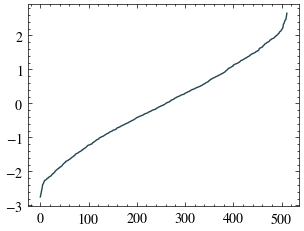

In [3]:
for i in range(len(energies)):
    plt.plot(energies[i], label=f"Run {i+1}")

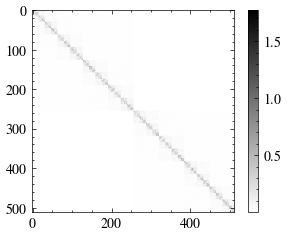

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.abs(hamil.hamil), cmap='gray_r')
plt.colorbar()

In [5]:
import Algebra.hamil_jit_methods as hjit
hamiltonian = hamil.hamil
hjit.energy_width(hamiltonian)


792.6741042935773

### Test the bandwidths prediction

In [5]:
import numpy as np
import Algebra.hamil_jit_methods as hjit

N       = 1
# nss     = np.array([5, 6, 7, 8, 9, 10, 11, 12, 13])
# nrealiz = [200, 150, 120, 100, 70, 50, 20, 10, 2]
nss     = np.array([5, 6, 7, 8, 9, 10, 11, 12])
# nss     = np.array([5, 6, 7, 8])
nrealiz = [20, 20, 20, 10, 5, 3, 1, 1]
alphas  = np.array([0.9, 0.3])
alphas  = np.array([0.96, 0.86, 0.71, 0.5, 0.2])
widths  = {(alpha, ns) : [] for ns in nss for alpha in alphas}
bwidths = {(alpha, ns) : [] for ns in nss for alpha in alphas}
mlvls   = {(alpha, ns) : [] for ns in nss for alpha in alphas}
gaps    = {(alpha, ns) : [] for ns in nss for alpha in alphas}
for ins, ns in enumerate(nss):
    nh      = 2**ns
    for alpha in alphas:
        hamil   = UltrametricModel(ns=ns, hilbert_space=None, n=N, J=1,
                            alphas=alpha, backend=backend, dtype='float64')
        for i in range(nrealiz[ins]):
            # print("Realization:", i, "for alpha:", alpha, "ns:", ns)
            
            # randomize the Hamiltonian
            if i == 0:
                # build and diagonalize the Hamiltonian
                hamil.build(verbose=False, use_numpy=True)
                hamil.diagonalize(verbose=False)
            else:
                hamil.randomize()
                hamil.diagonalize(verbose=True)
            # calculate the energy width
            energy_width = hjit.energy_width(hamil.hamil) / nh
            mean_lvl_sp  = hjit.mean_level_spacing(hamil.eig_val)
            gap_ratio    = hjit.gap_ratio(hamil.eig_val)
            bandwidth    = hamil.eig_val[-1] - hamil.eig_val[0]
            widths[(alpha, ns)].append(energy_width)
            mlvls[(alpha, ns)].append(mean_lvl_sp)
            gaps[(alpha, ns)].append(gap_ratio)
            bwidths[(alpha, ns)].append(bandwidth)
        # print(f"Mean energy width for ns={ns}: {np.mean(widths[(alpha, ns)]):.3e}")

INFO:general_python.common.flog:241: 		->[Hamiltonian] Successfully set local energy functions...
INFO:general_python.common.flog:241: 	->[Hamiltonian] Diagonalization started using (standard)...
INFO:general_python.common.flog:241: 		->[Hamiltonian] Diagonalization (standard) completed in 0.001711 seconds.
INFO:general_python.common.flog:241: 	->[Hamiltonian] Diagonalization started using (standard)...
INFO:general_python.common.flog:241: 		->[Hamiltonian] Diagonalization (standard) completed in 0.002567 seconds.
INFO:general_python.common.flog:241: 	->[Hamiltonian] Diagonalization started using (standard)...
INFO:general_python.common.flog:241: 		->[Hamiltonian] Diagonalization (standard) completed in 0.002122 seconds.
INFO:general_python.common.flog:241: 	->[Hamiltonian] Diagonalization started using (standard)...
INFO:general_python.common.flog:241: 		->[Hamiltonian] Diagonalization (standard) completed in 0.001903 seconds.
INFO:general_python.common.flog:241: 	->[Hamiltonian] Diag

In [8]:
print(np.var(hamil.eig_val))
hamil

1.057218743324958


UltrametricModel, ns=12, n=1, J=1.000, gamma=1.000, alphas=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

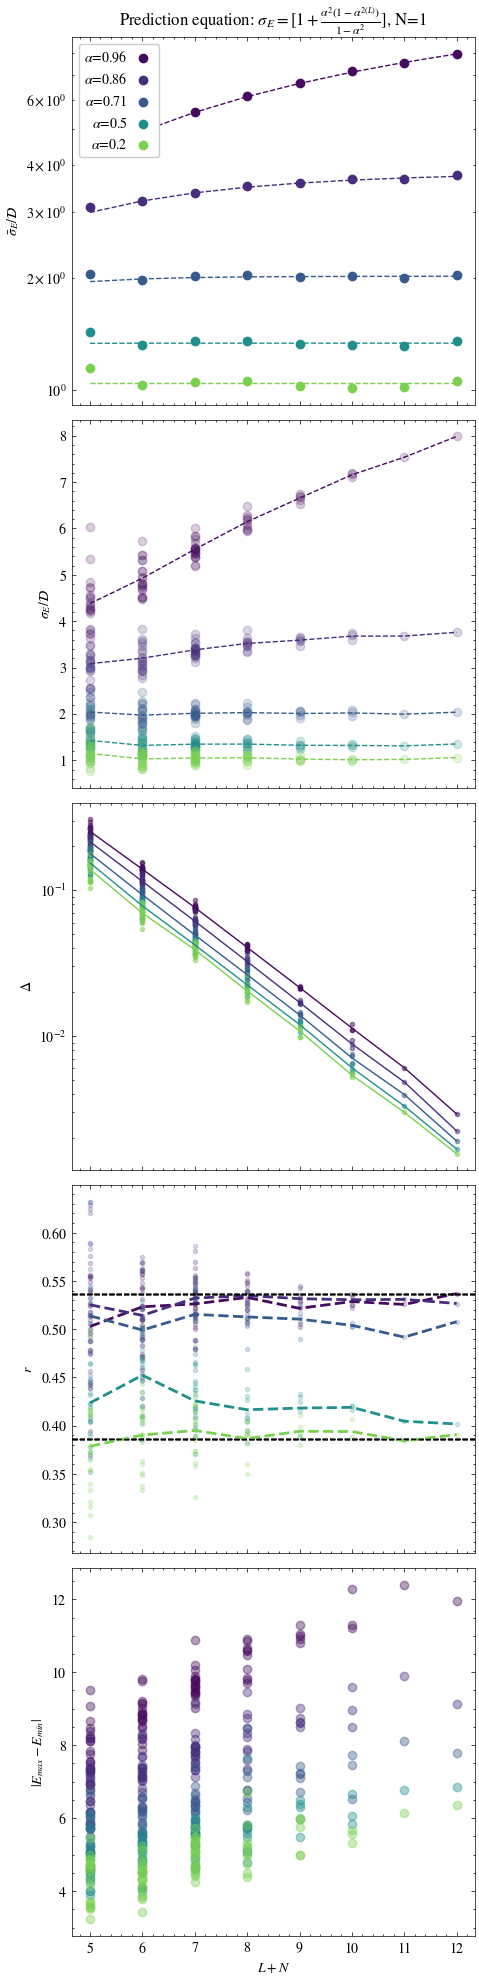

In [6]:
import matplotlib.pyplot as plt
import general_python.common.plot as plotter
from scipy.optimize import curve_fit

fig, ax = plotter.Plotter.get_subplots(5, 1, 5, 20, sharex = True)
ax[0].set_title(r'Prediction equation: $\sigma_E = [1 + \frac{\alpha^2 (1 - \alpha^{2(L)})}{1 - \alpha^2}]$, N=' + str(N))

for alpha in alphas:
    getcolor, colors, norm  = plotter.Plotter.get_colormap(np.arange(0, 1, 1e-2), 'viridis_r')
    color                   = getcolor(alpha)

    # fit the prediction to the function
    # prediction_fit  = lambda L, c: c * (1 + (alpha**2 * (1 - alpha ** (2*(L-N)))) / (1 - alpha**2))
    # popt, pcov      = curve_fit(prediction_fit, nss, [np.mean(widths[(alpha, ns)]) for ns in nss], p0=[1.0])
    # predictions     = prediction_fit(nss, *popt)
    prediction      = lambda L: (1 + (alpha**2 * (1 - alpha ** (2*(L-N)))) / (1 - alpha**2))
    predictions     = prediction(nss)
    y               = [np.mean(widths[(alpha, ns)]) for ns in nss]
    ax[0].scatter(nss, y, color=color, label=f'$\\alpha$={alpha}')
    ax[0].plot(nss, predictions, color=color, linestyle='--')
    for ns in nss:
        yin         = np.array(widths[(alpha, ns)])
        ax[1].scatter([ns] * len(yin), yin, color=color, alpha=0.2)
    ax[1].plot(nss, y, color=color, label=f'$\\alpha$={alpha}', linestyle='--')
    
    # mean level spacing
    for ns in nss:
        y           = np.array(mlvls[(alpha, ns)])
        ax[2].scatter([ns] * len(y), y, color=color, alpha=0.5, marker = '.')
    ax[2].plot(nss, [np.mean(mlvls[(alpha, ns)]) for ns in nss], color=color, label=f'$\\alpha$={alpha}', linestyle='-')
    # gap ratio
    for ns in nss:
        y           = np.array(gaps[(alpha, ns)])
        ax[3].scatter([ns] * len(y), y, color=color, alpha=0.2, marker = '.')
    ax[3].plot(nss, [np.mean(gaps[(alpha, ns)]) for ns in nss], color=color, label=f'$\\alpha$={alpha}', linestyle='--', lw = 2)
    ax[3].axhline(y=0.5359, color='k', linestyle='--', label='GOE')
    ax[3].axhline(y=0.3862, color='k', linestyle='--', label='Poisson')
    # bandwidth
    for ns in nss:
        y           = np.array(bwidths[(alpha, ns)])
        ax[4].scatter([ns] * len(y), y, color=color, alpha=0.4)

ax[0].set_ylabel(r'$\bar \sigma_E/\mathcal{D}$')
ax[1].set_ylabel(r'$\sigma_E/\mathcal{D}$')
ax[2].set_ylabel(r'$\Delta$')
ax[3].set_ylabel(r'$r$')
ax[4].set_xlabel(r'$L+N$')
ax[4].set_ylabel(r'$|E_{max} - E_{min}|$')

plotter.Plotter.set_legend(ax[0], loc='upper left', frameon=True)
# ax[0].legend()
ax[0].set_yscale('log')
ax[2].set_yscale('log')
plt.tight_layout()
# plt.yscale('log')
plt.savefig('ultrametric_energy_width_small.png')

## Quantum Sun Model

In [ ]:
from Algebra.Model.Interacting.Spin.qsm import QSM
backend = 'np'
hamil   = QSM(ns=6, hilbert_space=None, n=3, a=0.64, h=1.0, xi=0.2, backend=backend, dtype='float64')
hamil.h

#### Build

##### Sparse

In [ ]:
hamil.build(verbose=True, use_numpy=True)
print(f"Memory:{hamil.memory_gb:.3e}gb")

In [ ]:
hamil.diagonalize(verbose=True)

In [ ]:
hamil.eig_val[-5:]

In [ ]:
from general_python.physics.eigenlevels import gap_ratio
gap_ratio(hamil.eig_val, 1.0)['mean']

In [ ]:
np.sqrt(np.trace((hamil.hamil * hamil.hamil).todense()))

##### Dense

In [ ]:
hamil.to_dense()

In [ ]:
hamil.build(verbose=True, use_numpy=True)

In [ ]:
hamil.diagonalize(verbose=True)

In [ ]:
hamil.h_memory_gb

##### Plot tests

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hamil.eig_val)
hamil.eig_val, hamil.eig_vec, hamil.eig_vec.shape

In [ ]:
import numpy as np
# make dense
qsm_dense   = hamil.hamil.todense() if hamil.sparse else hamil.hamil
minimum     = qsm_dense.min()
maximum     = qsm_dense.max()
qsm_dense   = np.abs(qsm_dense) / np.abs(qsm_dense).max()

print("Minimum value:", minimum)
print("Maximum value:", maximum)

plt.figure(figsize=(5, 5))
plt.imshow(qsm_dense, cmap='viridis')
plt.colorbar()
plt.title("Density Representation")
plt.show()

##### Operators

In [ ]:
from Algebra.Operator.operators_spin import sig_x, sig_z, OperatorTypeActing
from general_python.common import binary
import numpy as np

backend     = 'np'
ns          = 2
nh          = 2**ns   
sites       = [ns - 1]
# sites       = [0]
sig_x_op    = sig_x(ns = ns, type_act = OperatorTypeActing.Global, sites = sites)
sig_z_op    = sig_z(ns = ns, type_act = OperatorTypeActing.Global, sites = sites)
eye_first   = np.eye(2**(ns - 1))
eye_first

###### Check how it works on the base states

###### With states

In [ ]:
int_state_full          = 2**(ns) - 1
int_state_half          = 2**(ns - 1) - 1
int_state_half_size     = 2**(ns//2) - 1

# binary representation
backend_state           = binary.int2base(int_state_full, size=ns, backend=backend)
backend_state_half      = binary.int2base(int_state_half, size=ns, backend=backend)
backend_state_half_size = binary.int2base(int_state_half_size, size=ns//2, backend=backend)
# string representation
string_state            = binary.int2binstr(int_state_full, bits=ns)
string_state_half       = binary.int2binstr(int_state_half, bits=ns)
string_state_half_size  = binary.int2binstr(int_state_half_size, bits=ns)

# act on the integer states
for state in [int_state_full, int_state_half, int_state_half_size]:
    print()
    # sigma x
    print("Applying sigma_x")
    print(f"Acting on state {state} ({binary.int2binstr(state, bits=ns)})")
    resulting_state, resulting_value = sig_x_op(state)
    print(f"\tResulting state: {resulting_state[0]}")
    print(f"\tResulting value: {resulting_value}")
    print(f"\tBinary representation of resulting state: {binary.int2binstr(resulting_state[0], bits=ns)}")
    # sigma z
    print("Applying sigma_z")
    resulting_state, resulting_value = sig_z_op(state)
    print(f"Resulting state: {resulting_state[0]}")
    print(f"Resulting value: {resulting_value}")
    print(f"Binary representation of resulting state: {binary.int2binstr(resulting_state[0], bits=ns)}")
    print()


###### With Hamiltonian

###### Matrix

In [ ]:
import numpy as np
from Algebra.Model.Interacting.Spin.qsm import QSM
from general_python.algebra.linalg import act, overlap
from general_python.common.plot import Plotter, colorsCycle
from general_python.maths.statistics import Statistics, HistogramAverage, Fraction
from Algebra.Operator.operators_spin import sig_x, sig_z, OperatorTypeActing
import matplotlib.pyplot as plt
from tqdm import tqdm

dtype           = 'float64'
nrealizations   = (np.array([100, 100, 100, 50, 30, 20])/5).astype(int)
# nrealizations   = (np.array([1, 1, 1, 1, 1, 1])).astype(int)
alpha           = 0.8
histograms_x    = {}
histograms_z    = {}
diagonals_x     = {}
diagonals_z     = {}
energies        = {}
nss             = [6,7,8,9,10]
# nss             = [10, 11]

# nss             = [9,10,11]
# nrealizations   = [10]

def set_histogram(hamiltonian, hist_sig_x: HistogramAverage, hist_sig_z: HistogramAverage, nbins):
    bandwidth       = hamiltonian.get_bandwidth()
    omax            = bandwidth * 3
    omin            = 0.1 / hamiltonian.hilbert_size
    tolerance       = 0.02 * bandwidth
    hist_sig_x.reset(nbins=nbins)
    hist_sig_x.uniform_log(v_max=omax, v_min=omin)
    hist_sig_z.reset(nbins=nbins)
    hist_sig_z.uniform_log(v_max=omax, v_min=omin)
    return tolerance

for ii, ns in enumerate(nss):
    realizations    = nrealizations[ii] if ii < len(nrealizations) else nrealizations[-1]
    energies[ns]    = []
    diagonals_x[ns] = []
    diagonals_z[ns] = []
    nh              = 2**ns
    # sites           = [0]
    sites           = [ns - 1]
    # sites           = [0]
    sig_x_op        = sig_x(ns = ns, type_act = OperatorTypeActing.Global, sites = sites)
    sig_z_op        = sig_z(ns = ns, type_act = OperatorTypeActing.Global, sites = sites)
    sig_x_op_mat    = sig_x_op.matrix(dim = nh, matrix_type = 'sparse', use_numpy = True)
    sig_z_op_mat    = sig_z_op.matrix(dim = nh, matrix_type = 'sparse', use_numpy = True)
    histogram_sig_x = HistogramAverage(dtype=dtype)
    histogram_sig_z = HistogramAverage(dtype=dtype)
    nbins           = int(20 * np.log2(nh))
    tolerance       = 0.0
    for realization in tqdm(range(realizations)):
        # print(f"Realization {realization + 1}/{nrealizations}")
        hamil       = QSM(ns=ns, hilbert_space=None, n=3, a=alpha, h=1.0, xi=0.2, backend = 'np', dtype='float64')
        hamil.build(verbose=False, use_numpy=True)
        hamil.diagonalize(verbose=False)
        states      = hamil.eig_vec
        eigvals     = hamil.eig_val
        sig_x_elems = overlap(states, states, sig_x_op_mat, backend = backend)
        sig_z_elems = overlap(states, states, sig_z_op_mat, backend = backend)
        diag_sig_x  = sig_x_elems.diagonal()
        diag_sig_z  = sig_z_elems.diagonal()
        if realization == 0:
            tolerance = set_histogram(hamil, histogram_sig_x, histogram_sig_z, nbins)
        # get the average energy
        energy_at       = hamil.av_en
        # create the f_functions by taking the middle spectrum (%)
        w, i_idx, j_idx = Fraction.spectral_function_fraction(eigvals, energy_at, tolerance)
        ones            = np.ones_like(sig_x_elems)
        ones[i_idx, j_idx] = 0
        plt.imshow(ones)
        # fill the histogram
        sig_x_changed   = np.abs(sig_x_elems[i_idx, j_idx])**2
        sig_z_changed   = np.abs(sig_z_elems[i_idx, j_idx])**2
        histogram_sig_x.append(w, sig_x_changed)
        histogram_sig_z.append(w, sig_z_changed)
        diagonals_x[ns].append(diag_sig_x)
        diagonals_z[ns].append(diag_sig_z)
        energies[ns].append(eigvals)
    histograms_x[ns] = histogram_sig_x
    histograms_z[ns] = histogram_sig_z
    

In [ ]:
from general_python.physics.eigenlevels import gap_ratio
fig, ax     = Plotter.get_subplots(nrows=2, ncols=2, sizex=5, sizey=5, dpi=150)

# plot
for ii, ns in enumerate(energies.keys()):
    realizations = nrealizations[ii] if ii < len(nrealizations) else nrealizations[-1]
    nh          = 2**ns
    x           = energies[ns][0] / ns
    # x           = np.arange(nh)
    colors1, _, _= Plotter.get_colormap(nss, cmap='viridis')
    colors2, _, _= Plotter.get_colormap(nss, cmap='plasma_r')
    color1      = colors1(ns)
    color2      = colors2(ns)
    Plotter.scatter(ax[0], x, diagonals_x[ns][0], label=f'$L={ns}$', color=color1)
    Plotter.scatter(ax[1], x, diagonals_z[ns][0], label=f'$L={ns}$', color=color2)
    Plotter.set_ax_params(ax[0], xlabel='$i/L$', ylabel=r'$O_{ii}$', title=r'$\sigma_x$')
    Plotter.set_ax_params(ax[1], xlabel='$i/L$', ylabel=r'$O_{ii}$', title=r'$\sigma_z$')

    Plotter.scatter(ax[2], histograms_x[ns].bin_edges, histograms_x[ns].averages_av()*nh, label=f'$L={ns}$', color=color1)
    Plotter.scatter(ax[3], histograms_z[ns].bin_edges, histograms_z[ns].averages_av()*nh, label=f'$L={ns}$', color=color2)
    Plotter.set_ax_params(ax[2], xlabel=r'$\omega$', lim = {'y': (1e-4, 1e2)},
        ylabel=r'$\mathcal{D}|O_{ij}|^2$', scale={'x': 'log', 'y': 'log'})
    Plotter.set_ax_params(ax[3], xlabel=r'$\omega$', lim = {'y': (1e-4, 1e2)},
        ylabel=r'$\mathcal{D}|O_{ij}|^2$', scale={'x': 'log', 'y': 'log'})
    gap_ratios = [gap_ratio(energies[ns][i])['mean'] for i in range(realizations)]
    print(f"ns = {ns}, gap_ratio = {np.mean(gap_ratios)}")
    Plotter.set_legend(ax[2])
fig.tight_layout()

In [ ]:

d_en = np.diff(energies[8])
d_en = d_en / np.mean(d_en)
gap_ratios = np.minimum(d_en[:-1], d_en[1:]) / np.maximum(d_en[:-1], d_en[1:])
print(np.mean(gap_ratios))


# Linear algebra

In [ ]:
import general_python.algebra as algebra
a = algebra.AlgebraTests(backend='jax')
b = algebra.AlgebraTests(backend='numpy')

## Standard tests

### Change the basis with a unitary matrix

In [ ]:
a.change_basis(verbose=True)
b.change_basis(verbose=True)

### Change the basis of a matrix with a unitary matrix

In [ ]:
a.change_basis_matrix(verbose=True)

### Outer product

In [ ]:
a.outer(verbose=True)
b.outer(verbose=True)

### Kronecker product

In [ ]:
a.kron(verbose=True)

## Linear solvers

### Test through examples

In [ ]:
a = algebra.SolversTests(backend='numpy')
b = algebra.SolversTests(backend='jax')

In [ ]:
a.solver_test()

# Binary 

### Standard tests

In [ ]:
from general_python.common import binary
NUM         = 42
tests       = binary.BinaryFunctionTests()

In [ ]:
import numpy as np
integer     = np.int64(255)
integer     = 255
ns          = 8
i           = 0
pos         = ns - 1 - i
checked     = binary.check_int(integer, pos)

binary.int2binstr(integer, ns), checked, (1 << pos), binary.int2binstr((1 << pos), ns), integer & (1 << pos)

In [ ]:
tests.run_tests(NUM, spin_value = binary._BACKENDREPR)

In [ ]:
tests.run_tests(NUM, spin_value = binary._BACKENDREPR, backend = 'np')

### Test JAX

In [ ]:
from algebra import get_backend
import time 
from jax import numpy as jnp, random as jnpr
import numpy as np, numpy.random as npr
from jax import jit

seed = 1701

# Test the speed of the matrix multiplication
key_np = npr.seed(seed)
key_jnp = jnpr.key(seed)
size = 5000

def matrix_mult_test_jax(size=size):
    random_mat  = jnpr.normal(key_jnp, (size, size))
    vec         = jnpr.normal(key_jnp, (size,))
    result      = random_mat @ vec
    print("Result of matrix-vector multiplication:\n", result)
    
def matrix_mult_test_numpy(size = size):
    random_mat  = npr.normal(size=(size, size))
    vec         = npr.normal(size=(size,))
    result      = random_mat @ vec
    print("Result of matrix-vector multiplication:\n", result)
    
@jit
def matrix_mult_test_jax_jit():
    random_mat  = jnpr.normal(key_jnp, (size, size))
    vec         = jnpr.normal(key_jnp, (size,))
    result      = random_mat @ vec
    print("Result of matrix-vector multiplication:\n", result)


#### Numpy

In [ ]:
start_time = time.time()
matrix_mult_test_numpy()
end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds (numpy)")

#### Jax

In [ ]:
start_time = time.time()
matrix_mult_test_jax()
end_time = time.time()
print(f"Time taken: {end_time - start_time:.4f} seconds (jax)")

#### Jax jit

In [ ]:
start_time = time.time()
matrix_mult_test_jax_jit()
end_time = time.time()  
print(f"Time taken: {end_time - start_time:.4f} seconds (jax, jitted)")

# Lattice


In [ ]:
from lattices import Lattice, run_lattice_tests

# Run tests for different configurations
# run_lattice_tests(dim=1, lx=10, ly=1, lz=1, bc=lattices.LatticeBC.PBC, typek="square")
# run_lattice_tests(dim=2, lx=5, ly=3, lz=1, bc=lattices.LatticeBC.PBC, typek="square")
# run_lattice_tests(dim=2, lx=5, ly=5, lz=1, bc=lattices.LatticeBC.OBC, typek="square")
# run_lattice_tests(dim=3, lx=3, ly=3, lz=3, bc=lattices.LatticeBC.PBC, typek="square")
run_lattice_tests(dim=2, lx=3, ly=2, lz=1, bc=lattices.LatticeBC.PBC, typek="honeycomb")

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

a = 1
b = 1
c = 1

Lx = 4
Ly = 2
Ns = 2 * Lx * Ly

_a1 = np.array([np.sqrt(3) * a / 2.0, 3 * a / 2.0, 0])
_a2 = np.array([np.sqrt(3) * a / 2.0, -3 * a / 2.0, 0])
_a3 = np.array([0, 0, c])



coords      = []
move_vector = _a1 - np.array([0, a, 0])
for i in range(Ns):
    # get the unit cell on a square lattic
    x = (i // 2) % Lx
    y = ((i//2) // Lx) % Ly
    
    # from coorditates to position on the lattice
    xy = np.array([0., 0, 0]) if i % 2 == 0 else move_vector
    xy += x * (_a1 + _a2) + y * _a1
    xp, yp = xy[0], xy[1]
    print(xp, yp)
    plt.scatter(xp, yp, color='red' if i % 2 == 0 else 'blue', marker='o', s=100, facecolor='none')
    plt.text(xp + 0.1, yp + 0.1, i)
    
    print("Ns=", i, "-- (x,y)=", x, y)


plt.arrow(0, 0, _a1[0], _a1[1], head_width=0.1, head_length=0.1, fc='r', ec='r')
plt.arrow(0, 0, _a2[0], _a2[1], head_width=0.1, head_length=0.1, fc='b', ec='b')
# plt.arrow(0, 0, _a1[0] - _a2[0], _a1[1] - _a2[1], head_width=0.1, head_length=0.1, fc='g', ec='g')
# plt.arrow(0, 0, _a1[0] + _a2[0], _a1[1] + _a2[1], head_width=0.1, head_length=0.1, fc='y', ec='y')
# plt.arrow(0, 0, -_a1[0] + _a2[0], -_a1[1] + _a2[1], head_width=0.1, head_length=0.1, fc='m', ec='m')
# plt.arrow(0, 0, -_a1[0] - _a2[0], -_a1[1] - _a2[1], head_width=0.1, head_length=0.1, fc='c', ec='c')


# NQS

## Sampler

<!-- #### Code Overview

This code sets up a computational experiment by combining a simple neural network with Monte Carlo sampling. Below is a breakdown of the major steps and components.

---

##### 1. Module Imports

- **Monte Carlo Sampling:**  
  The module `Solver.MonteCarlo.sampler` is imported as `Sampling` to provide Monte Carlo sampling functionality.

- **Backend Utilities:**  
  `get_backend` from `general_python.algebra.utils` is used to select a computational backend (e.g., NumPy) and obtain associated random number generators.

- **Neural Network Implementation:**  
  `SimpleNet` from `general_python.ml.net_impl.net_simple` is imported as a basic neural network class used for experimentation.

- **NumPy:**  
  Imported as `np` to support numerical operations.

---

##### 2. Backend Setup

- **Selection & Seed:**
  - **Backend:** Set to `"np"` (NumPy).
  - **Seed:** A seed of `1701` is specified to ensure reproducibility.

- **Obtaining Backend Modules:**  
  The function `get_backend` is called with parameters to ensure randomness (and optionally SciPy support). Its output is unpacked into:
  - `backend_np`: The NumPy backend.
  - `(rng, rng_k)`: Random number generators.
  - `backend_sp`: The SciPy backend (if available).

---

##### 3. Neural Network Configuration

- **State Shape:**  
  The input to the network is defined as a 10-dimensional vector (`st_shape = (10,)`).

- **Activation Functions:**  
  Two activation functions are specified: `'relu'` and `'sigmoid'`.

- **Network Initialization:**  
  A `SimpleNet` instance is created with:
  - **Input Shape:** `(10,)`
  - **Output Shape:** `(1,)`
  - **Layers:** A tuple `(5,)` indicating the network has 5 layers.
  - **Backend:** Specified as `'np'`.
  - **Data Type:** `'complex128'`, enabling complex-valued computations.

---

##### 4. Monte Carlo Sampler Configuration

- **Sampler Initialization:**  
  An instance of `Sampling.MCSampler` is created to perform Monte Carlo sampling on the neural network.

- **Key Parameters:**
  - **Network (`net`):** The previously defined `SimpleNet` instance.
  - **Shape:** The state shape `(10,)`.
  - **Random Number Generators:** `rng` and `rng_k` ensure randomness in the sampling process.
  - **Chains & Samples:** Configured to run 10 chains with 5 samples each.
  - **Sweep Steps & Thermalization:** Set to 10 steps each, controlling the progression and stabilization of the Monte Carlo simulation.
  - **Backend:** Uses the specified NumPy backend.

---

##### 5. Final Outcome

The final product is the `sampler` object, which encapsulates both the neural network and the Monte Carlo sampling parameters. This setup is ready to run experiments, allowing exploration of the network's state space through stochastic sampling.

---

**Summary:**  
This code initializes a complex-valued neural network and configures a Monte Carlo sampler to perform experiments. It ensures reproducibility with a fixed seed and leverages a specified backend (NumPy) along with associated random number generators, thereby preparing the system for robust computational experiments. -->


In [ ]:
import Solver.MonteCarlo.sampler as Sampling
from general_python.algebra.utils import get_backend
from general_python.ml.net_impl.net_simple import SimpleNet
import numpy as np

# get random backend
backend                                 = 'jax'
seed                                    = 1701
be_modules                              = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp    = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

ns                                      = 10
st_shape                                = (ns, )
activations                             = ('relu', 'sigmoid')
net                                     = SimpleNet(act_fun =   activations, 
                                            input_shape     =   st_shape, 
                                            output_shape    =   (1, ),
                                            layers          =   (5, ),
                                            backend=backend, dtype='complex128',)
            # [random.random() + 1j * random.random() for _ in range(x.shape[0])])
# a simple callable network function

sampler = Sampling.MCSampler(
    net         = net,
    shape       = st_shape,
    rng         = rng,
    rng_k       = rng_k,
    numchains   = 10,
    numsamples  = 5,
    sweep_steps = 10,
    backend     = backend,
    therm_steps = 10,
)

sampler

In [ ]:
# check how the sampler performs
(states, logprobas), (configs, configs_ansatze), probabilities = sampler.sample()

In [ ]:
# final states after sampling, ansatze after sampling
states.shape, logprobas.shape

In [ ]:
configs.shape, configs_ansatze.shape, probabilities.shape

### Flow

#### Standard

In [ ]:
from general_python.common.plot import MatrixPrinter

print("Detailed Flow of the Configurations:\n")
print(f"  Total number of configurations: {len(configs)}")
print(f"  Total number of states: {len(states)}")
print(f"  Total number of probabilities: {len(probabilities)}\n")

for i in range(len(configs[:3])):
    print(f"--- Configuration flow {i} ---")
    print("     Configuration \\(\\mathbf{S}_{" + f"{i}" + "}\\):")
    MatrixPrinter.print_vector(configs[i])
    
    print("    Ansatz \\(f(\\mathbf{S}_{" + f"{i}" + "})\\):")
    MatrixPrinter.print_vector(configs_ansatze[i].T)
    
    print("    Probability \\(P(\\mathbf{S}_{" + f"{i}" + "})\\):")
    MatrixPrinter.print_vector(probabilities[i].T)
    print("\n" + "-" * 50 + "\n")


#### Flattened

In [ ]:
from general_python.common.plot import MatrixPrinter

# -----------------------------------------------------------------
# Flatten the configurations and ansatz arrays with a clearer mathematical description
#
# Let 𝒞 ∈ ℝ^(N×d) represent the configuration matrix, where:
#   N = number of samples (configurations)
#   d = st_shape[0] (the dimension of each configuration)
#
# Similarly, for the ansatz values f(𝒞) (one per configuration), we flatten the array.
# -----------------------------------------------------------------

# Reshape configurations to a 2D array: each row is one configuration vector.
configs_flat = configs.reshape(-1, st_shape[0])
print("Shape of flattened configurations (𝒞):", configs_flat.shape)

# Flatten the ansatze: each configuration has a single ansatz value.
configs_ansatze_flat = configs_ansatze.reshape(-1)
print("Shape of flattened ansatze (f(𝒞)):", configs_ansatze_flat.shape)

print("\nDetailed flow of the configurations:")
print("Number of configurations:", len(configs_flat))
print()

# -----------------------------------------------------------------
# For the first 5 configurations, print:
#   - The configuration vector 𝒞ᵢ
#   - The ansatz from the network f(𝒞ᵢ)
#   - A verification whether f(𝒞ᵢ) matches the ansatz given by the sampler.
# -----------------------------------------------------------------
for i in range(len(configs_flat[:5])):
    print(f"--- Configuration {i} ---")
    
    print("\tConfiguration (𝒞):")
    print("\t", configs_flat[i])
    # MatrixPrinter.print_vector(configs_flat[i]
    
    print("'\tAnsatz from sampler (f(𝒞)):")
    # Compute the ansatz from the network using the configuration.
    print("\t", configs_ansatze_flat[i])
    ansatz_net = net(configs_flat[i])
    print("\tAnsatz from the network:")
    print("\t", ansatz_net)
    
    # Verify if the network's ansatz equals the sampler's ansatz.
    is_same = np.allclose(ansatz_net, configs_ansatze_flat[i])
    print("\tVerification (f(𝒞) from network ?= sampler's ansatz):", is_same)
    
    print("\n-------------------------\n")


## Solver class

Below, we:

1. Create a simple network for the NQS ansatz
2. Create a sampler
3. Create a dummy Hamiltonian

In [ ]:
import NQS.nqs as nqsmodule
import Solver.MonteCarlo.sampler as Sampling
from Algebra.Model.dummy import DummyHamiltonian
from general_python.algebra.utils import get_backend
from general_python.ml.net_impl.net_simple import SimpleNet

import numpy as np

# get random backend
# backend             = 'np'
backend             = 'jax'
seed                = 1701
dtypex              = complex
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

# get the network
ns                  = 20
st_shape            = (ns, )
activations         = ('relu', 'sigmoid')
net                 = SimpleNet(act_fun =   activations, 
                        input_shape     =   st_shape, 
                        output_shape    =   (1, ),
                        layers          =   (5, ),
                        backend         =   backend_np,
                        dtype           =   dtypex)

# get the sampler
sampler             = Sampling.MCSampler(
                            net         = net,
                            shape       = st_shape,
                            rng         = rng,
                            rng_k       = rng_k,
                            numchains   = 10,
                            numsamples  = 5,
                            sweep_steps = 30,
                            backend     = backend_np,
                            therm_steps = 10,
                        )

# get the Hamiltonian
# ham_dtype           = complex
ham_dtype           = float
par                 = 0.5 + 1j * 0.5 if ham_dtype == complex else 0.5
ham                 = DummyHamiltonian(hilbert_space=None, ns = ns, backend = backend, dtype = ham_dtype)
batch_size          = 1

nqs                 = nqsmodule.NQS(
                            net         = net,
                            sampler     = sampler,
                            hamiltonian = ham,
                            lower_betas = None,
                            lower_states= None,
                            seed        = seed,
                            beta        = 1.0,
                            shape       = st_shape,
                            backend     = backend,
                            nthread     = 1,
                            batch_size  = batch_size)

In [ ]:
sampler

In [ ]:
(states, logprobas), (configs, configs_ansatze), probabilities = nqs.sample(num_samples=5, num_chains=5)
configs.shape

In [ ]:
from flax.training.train_state import TrainState
import matplotlib.pyplot as plt
import optax

# try to train the network

n_epo       = 150
batch_size  = 10
history     = []
sr          = nqs.sr
# Initialize the optimizer
# lr          = optax.linear_schedule(init_value=0.001, end_value=0.0001, transition_steps=1000)
# optimizer   = optax.adam(learning_rate=lr)
lr          = 6e-3
# Create a TrainState to manage the model parameters and optimizer state
# train_state = TrainState.create(apply_fn=net.apply, params=net.get_params(), tx=optimizer)

for i in range(n_epo):
    print(f"Epoch {i + 1}/{n_epo}")
    
    # collect the samples
    (states, logprobas), (configs, configs_ansatze), probabilities = nqs.sample()
    print(f"  Number of configurations: {configs.shape}")
    print(f"  Configs and ansatze: {configs_ansatze.shape}")
    print(f"  Number of states: {states.shape}")
    print(f"  Number of probabilities: {probabilities.shape}\n")
    
    # collect the energies
    (configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(
        states_and_psi  = (configs, configs_ansatze),
        probabilities   = probabilities,
        functions       = None,     # means that we evaluate energy
        batch_size      = batch_size
    )
    # print(f"  Energies: {v.shape}")
    # print(f"  Mean energy: {means}, std: {stds}")
    # print(f"  Configurations: {configs.shape}")
    
    # get the gradients
    # grad = nqs.gradient(states=configs, batch_size=batch_size)
    
    # try to calculate the stochastic reconfiguration
    # sr.set_values(loss=v, derivatives=grad, mean_loss=means, mean_deriv=None, calculate_s=True, use_minsr=False)

    # f = sr.forces
    # s = sr.covariance_matrix
    # print(f"  Forces: {f.shape}")
    # if s is not None:
        # print(f"  Covariance matrix: {s.shape}")
    
    # try to calculate the gradient through the stochastic reconfiguration
    # s_inv   = jnp.linalg.pinv(s, rtol = 1e-3)
    # print(f"  Inverse covariance matrix: {s_inv.shape}")
    # df      = lr * jnp.dot(s_inv, f)
    # df = jnp.linalg.solve(s, f)
    # print(f"  Gradient through the stochastic reconfiguration: {df.shape}")
    
    # Update the network parameters using TrainState
    
    # new_params      = train_state.apply_gradients(grads={"params":df})
    # nqs.update_parameters(df)
    # updates, new_opt_state  = train_state.tx.update(df, train_state.opt_state, train_state.params)
    # new_params              = optax.apply_updates(train_state.params, updates)
    # train_state             = train_state.replace(params=new_params, opt_state=new_opt_state)
    
    # history.append(means)
    

plt.plot(history)

# Number of configurations: (25, 10)
# Configs and ansatze: (25, 1)
# Number of states: (5, 10)
# Number of probabilities: (25, 1)

## Test flax networks

In [ ]:
import NQS.nqs as nqsmodule
import Solver.MonteCarlo.sampler as Sampling
from general_python.algebra.utils import get_backend
from general_python.ml.net_impl.networks.net_rbm import RBM

import numpy as np
import jax.numpy as jnp

#! Hamiltonian
from Algebra.Model.Interacting.Spin.transverse_ising import TransverseFieldIsing
from general_python.lattices.square import SquareLattice
from general_python.lattices.lattice import LatticeBC

# get random backend
backend             = 'jax'
seed                = 1234
dtypex              = jnp.complex128
be_modules          = get_backend(backend, random=True, seed=seed, scipy=True)
backend_np, (rng, rng_k), backend_sp = be_modules if isinstance(be_modules, tuple) else (be_modules, (None, None), None)

# get the network
ns                  = 12
st_shape            = (ns, )
net                 =   RBM(
    input_shape     = st_shape, 
    n_hidden        = 2*ns,
    dtype           = dtypex,
    seed            = seed,
    visible_bias    = True,
    bias            = True
)
sampler             =   Sampling.MCSampler(
    net             = net,
    shape           = st_shape,
    rng             = rng,
    rng_k           = rng_k,
    numchains       = 10,
    numsamples      = 100,
    sweep_steps     = ns,
    backend         = backend_np,
    therm_steps     = 25,
    mu              = 2.0,
    seed            = seed
)

# get the Hamiltonian
ham_dtype           = jnp.float64
lattice             =   SquareLattice(
    dim             = 1, 
    lx              = ns, 
    ly              = 1, 
    lz              = 1, 
    bc              = LatticeBC.PBC
)

j                   = -1.0   
g                   = -0.5   
h                   = 0.5
ham                 =   TransverseFieldIsing(
    lattice         = lattice,
    hilbert_space   = None,
    j               = j,
    hz              = h,
    hx              = g,
    dtype           = ham_dtype,
    backend         = backend_np
)

nqs                 =   nqsmodule.NQS(
    net             = net,
    sampler         = sampler,
    hamiltonian     = ham,
    lower_betas     = None,
    lower_states    = None,
    seed            = seed,
    beta            = 1.0,
    mu              = sampler.get_mu(),
    shape           = st_shape,
    backend         = backend_np,
    nthread         = 1,
    batch_size      = 1
)

### Local energy

In [ ]:
import general_python.common.binary as binary

int_state       = np.random.randint(0, 2**ham.ns)
print(f"Integer state: {int_state}")
loc_energy_int  = []
for i in range(ham.ns):
    loc_energy_int.append(ham.loc_energy_int(int_state, i))
loc_states_int  = [i[0] for i in loc_energy_int]
loc_energy_int  = [i[1] for i in loc_energy_int]
print(loc_states_int)
# flatten the list
loc_energy_int  = [item for sublist in loc_energy_int for item in sublist]
loc_states_int  = [item for sublist in loc_states_int for item in sublist]
loc_energy_int_l= [loc_energy_int[i] for i in range(len(loc_energy_int)) if loc_states_int[i] == int_state]
loc_states_int_l= [loc_states_int[i] for i in range(len(loc_energy_int)) if loc_states_int[i] == int_state]
loc_energy_int  = [loc_energy_int[i] for i in range(len(loc_states_int)) if loc_states_int[i] != int_state]
loc_states_int  = [loc_states_int[i] for i in range(len(loc_states_int)) if loc_states_int[i] != int_state]
loc_energy_int  = [np.sum(loc_energy_int_l)] + loc_energy_int 
loc_states_int  = [int_state] + loc_states_int

jax_state       = binary.int2base(n = int_state, size = ham.ns, backend = 'np')
jax_state       = jnp.array(jax_state, dtype=jnp.float64)
loc_energy_jax  = ham.loc_energy_arr_jax(jax_state)
loc_states_jax  = loc_energy_jax[0]
loc_energy_jax  = loc_energy_jax[1]

print(len(loc_energy_int), len(loc_energy_jax))
print(len(loc_states_int), len(loc_states_jax))
for i in range(len(loc_energy_int)):
    print("i=", i)
    print(f"\tInt state: {loc_states_int[i]}, Energy: {loc_energy_int[i]}")
    print(f"\tInt state: {binary.base2int(loc_states_jax[i])}, Jax state: {loc_states_jax[i]}, Energy: {loc_energy_jax[i]}")


In [ ]:
# gradient
jax_state_reshape = jax_state.reshape(1, -1)
# jax_state_reshape = jnp.array([jax_state, jax_state], dtype=jnp.float64)
print(jax_state_reshape.shape)

# get the gradient - numerical
grad_num, shapes, sizes, is_cpx = nqs.gradient(states=jax_state_reshape, batch_size=1, params=net.get_params())
grad_num                = nqs.transform_flat_params(grad_num[0], shapes, sizes, is_cpx)
# print("Gradient - numerical:", grad_num)
# get the gradient - analytical
grad_anal_f, params = net.get_gradient()
grad_anal           = grad_anal_f(net.get_params(), jax_state_reshape)
# print("Gradient - analytical:", grad_anal)

# compare
for g, g_ in zip(grad_num, grad_anal):
    print(f"\nGradient Group: {g}")
    print("-" * 50)
    
    elem_num = grad_num[g]
    elem_anal = grad_anal[g_]
    
    if 'bias' in elem_num:
        bias_num = elem_num['bias']
        bias_anal = elem_anal['bias'][0]
        print("\tBias - Numerical:")
        print(f"\t{bias_num}")
        print(f"\tShape: {bias_num.shape}, dtype: {bias_num.dtype}")
        print("\tBias - Analytical:")
        print(f"\t{bias_anal}")
        print(f"\tShape: {bias_anal.shape}, dtype: {bias_anal.dtype}")
        bias_diff = bias_num - bias_anal
        print("\tBias Difference:")
        print(f"\t{bias_diff}")
    else:
        print(f"Numerical: {elem_num}")
    
    if 'kernel' in elem_num:
        kernel_num = elem_num['kernel']
        kernel_anal = elem_anal['kernel'][0]
        print("\tKernel - Numerical:")
        print(f"\t{kernel_num}")
        print(f"\tShape: {kernel_num.shape}, dtype: {kernel_num.dtype}")
        print("\tKernel - Analytical:")
        print(f"\t{kernel_anal}")
        print(f"\tShape: {kernel_anal.shape}, dtype: {kernel_anal.dtype}")
        kernel_diff = kernel_num - kernel_anal
        print("\tKernel Difference:")
        print(f"\t{kernel_diff}")
    else:
        print(f"Analytical: {elem_anal}")
        print(f"Numerical: {elem_num}")
        print(f"Difference: {elem_anal - elem_num}")
    
    # print("\nSummary for Group:")
    # print(f"\tNumerical: {elem_num}")
    # print(f"\tAnalytical: {elem_anal}")
    # print("-" * 50)


In [ ]:
grad_anal

### Sampler

In [ ]:
sampler

In [ ]:
import general_python.common.binary as binary

def do():
    (states, logprobas), (configs, configs_ansatze), probabilities = sampler.sample(num_samples=5, num_chains=5)
    for config in configs[:2]:
        print(config)
        print(binary.base2int(config))
        print()
%timeit -r 5 -n 5 do()
(states, logprobas), (configs, configs_ansatze), probabilities = sampler.sample(num_samples=5, num_chains=5)

In [ ]:
configs_ansatze

In [ ]:
net.apply(net.get_params(), configs)

In [ ]:
ham.loc_energy_arr_jax(configs[0])

In [ ]:
(configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(
    states_and_psi  = (configs, configs_ansatze),
    probabilities   = probabilities,
    functions       = None,     # means that we evaluate energy
    batch_size      = batch_size
)
v

In [ ]:
p = nqs.get_params().copy()
p

In [ ]:
params = net.get_params().copy()
params['visible_bias'] = jnp.array([0.1] * ns, dtype=params['visible_bias'].dtype)
nqs.update_parameters(params)
print(params['visible_bias'])
print(net.get_params()['visible_bias'])

In [ ]:
(configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(
    states_and_psi  = (configs, configs_ansatze),
    probabilities   = probabilities,
    functions       = None,     # means that we evaluate energy
    batch_size      = batch_size
)
v

In [ ]:
# set new parameters
net.set_params(params=p)
(configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(
    states_and_psi  = (configs, configs_ansatze),
    probabilities   = probabilities,
    functions       = None,     # means that we evaluate energy
    batch_size      = batch_size
)
v

### Train

#### PINV

In [ ]:
import general_python.algebra.solvers as solvers 

solver_linalg = solvers.choose_solver(solver_id=solvers.SolverType.PSEUDO_INVERSE)
solver_linalg_func = solver_linalg.get_solver_func(backend_module=backend_np)
solver_linalg

In [ ]:
import jax
n               = 100
random_matrix   = jnp.array(npr.normal(size=(n, n)), dtype=jnp.float64)
matrix          = (random_matrix + random_matrix.T) / 2  # Make the matrix symmetric
vector          = jnp.array(npr.normal(size=(n,)), dtype=jnp.float64)

@jax.jit
def matvec(x):
    return jnp.dot(matrix, x)
reg      = 1e-10
tol      = 1e-3
solution = solver_linalg_func(matvec=matvec, b=vector, x0=None,
                            tol=tol, sigma=reg, A=matrix)
%timeit -r 5 -n 5 solver_linalg_func(matvec=matvec, b=vector, x0=None, tol=tol, sigma=reg, A=matrix)
# Solve the linear system Ax = b
# solution = solver_linalg_func(matrix, vector)
matrix @ solution[0] - vector

In [ ]:
solution

#### OTHER

In [ ]:
import general_python.algebra.solvers as solvers 
import general_python.algebra.preconditioners as preconditioners

#! SOLVER
solver_linalg       = solvers.choose_solver(solver_id=solvers.SolverType.SCIPY_CG)
solver_linalg_func  = solver_linalg.get_solver_func(backend_module=backend_np,
                                        use_matvec=False, use_matrix=True, sigma=None)
reg                 = 1e-6

#! PRECONDITIONER
precond             = preconditioners.choose_precond(precond_id =   preconditioners.PreconditionersTypeSym.JACOBI,
                                                    backend     =   backend_np)
precond.sigma       = reg
precond

In [ ]:
import jax
import jax.numpy as jnp
import numpy.random as npr

n               = 100
random_matrix   = jnp.array(npr.normal(size=(n, n)), dtype=jnp.float64)
matrix          = (random_matrix + random_matrix.T) / 2  # Make the matrix symmetric
vector          = jnp.array(npr.normal(size=(n,)), dtype=jnp.float64)

#! set the preconditioner
precond_func    = precond.get_apply_mat()
precond_func    = lambda r, a: r
print(precond_func)



tol      = 1e-9
maxiter  = 2000
solution = solver_linalg_func(
        a               =   matrix,
        precond_apply   =   precond_func,
        b               =   vector, 
        x0              =   jnp.zeros_like(vector),
        tol             =   tol, 
        maxiter         =   maxiter)
%timeit -r 10 -n 5 solver_linalg_func(a=matrix, precond_apply=precond_func, b=vector, x0=jnp.zeros_like(vector), tol=tol, maxiter=maxiter)
# Solve the linear system Ax = b
# solution = solver_linalg_func(matrix, vector)
# if solution.converged:
    # print("Converged")
# else:
    # print("Did not converge")
print("Residual:", (matrix @ solution[0] - vector)[:5])
print("My solution:", solution[0][:5])

# solution from jax.scipy
from jax.scipy.sparse.linalg import cg
from jax import jit

@jit
def solve_cg(matrix, vector):
    return cg(matrix, vector, tol=tol, maxiter=maxiter, M=lambda r: r)

solution = solve_cg(matrix, vector)
print("Solution:", solution[0][:5])
print("Residual:", (matrix @ solution[0] - vector)[:5])

%timeit -r 5 -n 5 solve_cg(matrix, vector)
solution

#### Training

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import general_python.algebra.solvers.stochastic_rcnfg as SR
import jax.numpy as jnp
from tqdm import trange

import general_python.algebra.solvers as solvers
import general_python.algebra.preconditioners as preconditioners

#! Configuration
n_epo           =       500
batch_size      =       20
lr              =       5e-2
pinv            =       1e-8
sreg            =       1e-1

solver_linalg   =       solvers.choose_solver(solver_id=solvers.SolverType.SCIPY_CG, sigma=sreg)
precond         =       preconditioners.choose_precond(precond_id=preconditioners.PreconditionersTypeSym.JACOBI, backend='jax')
# precond.sigma   =       sreg
precond_apply   =       precond.get_apply_gram()
# precond_apply   =       lambda r, s, sp: r

# Ensure solver function gets sigma correctly
solver_linalg_func = solver_linalg.get_solver_func(backend_module=backend_np,
                                        use_matvec  =   False, # Set True if you provide matvec, False if using Fisher S matrix
                                        use_matrix  =   False, # Set True to form full S matrix (memory intensive!)
                                        use_fisher  =   True,  # Indicates S matrix or matvec is Fisher info
                                        sigma       =   sreg)  # Pass regularization here

#### Train loop big

In [ ]:
# %load_ext line_profiler

#! Initialization
history                 =       []
sampling_times          =       []
evaluation_times        =       []
gradient_times          =       []
reconfiguration_times   =       []
update_times            =       []
epoch_times             =       [] # To store total time per epoch

#! Initial values for display before first epoch calculation
means                   =       float('nan')
stds                    =       float('nan')

def train_function():
    #! Training Loop with tqdm
    # Use trange outside the loop variable assignment to get the progress bar object
    pbar                    = trange(n_epo, desc="Starting Training...", leave=True)
    for i in pbar:
        epoch_start_time = time.time() # Time the whole epoch

        #! 1. Sampling
        start_time      =       time.time()
        (states, logprobas), (configs, configs_ansatze), probabilities = nqs.sample(reset=False)
        sample_time     =       time.time() - start_time
        sampling_times.append(sample_time)

        #! 2. Energy Evaluation
        start_time      =       time.time()
        # Need to handle potential errors from evaluate_fun if sampling failed
        try:
            (configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(
                states_and_psi  = (configs, configs_ansatze),
                probabilities   = probabilities,
                functions       = None, # means that we evaluate energy
                batch_size      = batch_size
            )
        except Exception as e:
            print(f"\nError during energy evaluation in epoch {i+1}: {e}")
            print("Stopping training.")
            break
        eval_time       =       time.time() - start_time
        evaluation_times.append(eval_time)

        # Check for NaN in energy early
        if np.isnan(means):
            print(f"\nNaN detected in energy calculation at epoch {i+1}, stopping training.")
            # Optionally print some state info for debugging
            # print("Last configs:", configs)
            break

        #! 3. Gradient Computation
        start_time      =       time.time()
        try:
            grad        =       nqs.gradient(states=configs, batch_size=batch_size, params=nqs.get_params())
            # print(grad.shape)
        except Exception as e:
            print(f"\nError during gradient calculation in epoch {i+1}: {e}")
            print("Stopping training.")
            break # Exit loop on gradient error
        grad_time       =       time.time() - start_time
        gradient_times.append(grad_time)

        #! 4. Stochastic Reconfiguration
        start_time      =       time.time()
        try:
            # Ensure v (loss) and grad (var_deriv) are correctly shaped and typed
            # v should be (n_samples,) real array (E_loc - E_mean)
            # grad should be (n_samples, n_params) complex array (O_k or O_k^*)
            if not isinstance(v, (np.ndarray, jnp.ndarray)) or v.ndim != 1:
                print(f"\nWarning: Unexpected format for 'loss' (v) in epoch {i+1}. Shape: {getattr(v, 'shape', 'N/A')}")
            if not isinstance(grad, (np.ndarray, jnp.ndarray)) or grad.ndim != 2:
                print(f"\nWarning: Unexpected format for 'var_deriv' (grad) in epoch {i+1}. Shape: {getattr(grad, 'shape', 'N/A')}")

            # Ensure x0 matches the *complex* dtype of the expected solution
            # SR solution df.x should match gradient complexity
            expected_dtype  = grad.dtype
            x0_sr           = jnp.zeros_like(grad[0, :], dtype=expected_dtype)
            df              =       SR.solve_jax(
                solve_func      = solver_linalg_func,
                loss            = v,
                var_deriv       = grad,
                min_sr          = False,
                x0              = x0_sr,
                precond_apply   = precond_apply,
                maxiter         = 500,
                tol             = pinv
            )
            # s_c             =  SR.derivatives_centered_jax(grad, jnp.mean(grad, axis = 0))
            # s_c_h           =  jnp.conjugate(s_c.T)
            # loss_c          =  SR.loss_centered_jax(v, means)
            # df              =  SR.gradient_jax(s_c_h, loss_c, loss_c.shape[0])
            # df              =  solvers.SolverResult(x=df, converged=True, residual_norm=None, iterations=None)
        except Exception as e:
            print(f"\nError during SR calculation in epoch {i+1}: {e}")
            print(f"SR Input shapes/dtypes: loss={v.shape}/{v.dtype}, var_deriv={grad.shape}/{grad.dtype}")
            print("Stopping training.")
            break
        reconfig_time       =       time.time() - start_time
        reconfiguration_times.append(reconfig_time)

        #! 5. Update Network Parameters
        start_time          =       time.time()
        try:
            # The update step: parameters = parameters - learning_rate * df.x
            # nqs.update_parameters expects the full step (-lr * df.x)
            nqs.update_parameters(df.x, -lr)
        except Exception as e:
            print(f"\nError during parameter update in epoch {i+1}: {e}")
            print(f"Update step shape/dtype: {df.x.shape}/{df.x.dtype}")
            print("Stopping training.")
            break
        update_time         =       time.time() - start_time
        update_times.append(update_time)

        # --- Store history and update progress bar ---
        history.append(means)
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        # Update tqdm description and postfix
        pbar.set_description(f"Epoch {i + 1}/{n_epo}")
        postfix_dict = {
            "E_mean"    : f"{means:.6f}",
            "E_std"     : f"{stds:.4f}",
            "t_samp"    : f"{sample_time:.3e}s",
            "t_eval"    : f"{eval_time:.3e}s",
            "t_grad"    : f"{grad_time:.3e}s",
            "t_sr"      : f"{reconfig_time:.3e}s",
            "t_update"  : f"{update_time:.3e}s",
            "t_epoch"   : f"{epoch_time:.3e}s"
        }
        pbar.set_postfix(postfix_dict, refresh=True)
        # print(nqs.get_params())

    #! End of Loop
    pbar.close()
    return history, sampling_times, evaluation_times, gradient_times, reconfiguration_times, update_times, epoch_times


# %lprun -f train_function history, sampling_times, evaluation_times, gradient_times, reconfiguration_times, update_times, epoch_times = train_function()
# %lprun -f train_function history, sampling_times, evaluation_times, gradient_times, reconfiguration_times, update_times, epoch_times = train_function()

history, sampling_times, evaluation_times, gradient_times, reconfiguration_times, update_times, epoch_times = train_function()

#! Final Summary
if history:
    print("\n--- Training Finished ---")
    print(f"Completed {len(history)} epochs.")
    print(f"Final Mean Energy: {history[-1]:.6f}")

    # Calculate averages only on successful steps
    avg_sampling_time           = np.mean(sampling_times) if sampling_times else float('nan')
    avg_evaluation_time         = np.mean(evaluation_times) if evaluation_times else float('nan')
    avg_gradient_time           = np.mean(gradient_times) if gradient_times else float('nan')
    avg_reconfiguration_time    = np.mean(reconfiguration_times) if reconfiguration_times else float('nan')
    avg_epoch_time              = np.mean(epoch_times) if epoch_times else float('nan')
    avg_update_time             = np.mean(update_times) if update_times else float('nan')

    print("\nTiming Summary (Average per epoch):")
    print(f"{'Step':<30}{'Average Time (s)':<20}")
    print(f"{'-'*50}")
    print(f"{'Sampling':<30}{avg_sampling_time:<20.3e}")
    print(f"{'Energy Evaluation':<30}{avg_evaluation_time:<20.3e}")
    print(f"{'Gradient Computation':<30}{avg_gradient_time:<20.3e}")
    print(f"{'Stochastic Reconfiguration':<30}{avg_reconfiguration_time:<20.3e}")
    print(f"{'Parameter Update':<30}{avg_update_time:<20.3e}")
    print(f"{'Total Epoch':<30}{avg_epoch_time:<20.3e}")

    # --- Plotting ---
    plt.figure(1)               # Create a new figure
    plt.plot(np.real(history))  # Plot real part of energy history
    plt.xlabel("Epoch")
    plt.ylabel("Mean Energy")
    plt.title("Training Progress (Mean Energy)")
    plt.grid(True)
    plt.show()
else:
    print("\nTraining did not complete any epochs.")

#### Train loop small

In [ ]:
%load_ext line_profiler

sr_options = SR.SRParams(
    min_sr          = False,
    maxiter         = 500,
    tol             = 1e-8,
    reg             = 1.0,
    # Solver parameters
    solver_form_s   = False,
)

solver_fun  = solver_linalg_func
precond_fun = precond_apply
print(solver_fun)
print(precond_fun)

# functions
ansatz      = nqs.ansatz
loc_energy  = nqs.local_energy
flat_grad   = nqs.flat_grad
batch_size  = 5
print(ansatz)
print(loc_energy)
print(flat_grad)

# @jax.jit

def single_step_train(i: int):
    #! Generate samples
    time_start  = time.time()
    (states, logprobas), (configs, configs_ansatze), probabilities = nqs.sample(reset=False)
    time_sample = time.time() - time_start

    #! Single step in the NQS
    time_start  = time.time()
    dpar, step_info, (shapes, sizes, iscpx) = nqs.single_step_jax(
        params              = nqs.get_params(),
        configs             = configs,
        configs_ansatze     = configs_ansatze,
        probabilities       = probabilities,
        apply_fn            = ansatz,
        local_energy_fun    = loc_energy,
        flat_grad_fun       = flat_grad,
        #! Stochastic reconfiguration
        use_sr              = True,
        sr_options          = sr_options,
        sr_precond_apply_fun= precond_fun,
        sr_solve_linalg_fun = solver_fun,
        batch_size          = batch_size,
    )
    time_single_step        = time.time() - time_start
    
    if step_info.failed:
        return None, (None, time_sample, time_single_step)
    
    #! Update the parameters
    time_start  = time.time()
    nqs.update_parameters(dpar, -lr, shapes, sizes, iscpx)
    time_update = time.time() - time_start
    
    #! Return the mean energy
    return step_info.mean_energy, (time_update, time_sample, time_single_step)

def train_function():
    energies = []
    for n in range(n_epo):
        
        time_start  = time.time() # Time the whole epoch
        mean_energy, (time_update, time_sample, time_single_step) = single_step_train(n)
        time_end    = time.time() - time_start
        
        if mean_energy is not None:
            energies.append(mean_energy)
            print(f"Epoch {n + 1}/{n_epo} - Step Info: {mean_energy}, t_up:{time_update:.3e}, t_s:{time_sample:.3e}, t_ss:{time_single_step:.3e}, t_epoch:{time_end:.3e}")
        else:
            print(f"Epoch {n + 1}/{n_epo} - Step failed, stopping training.")
            break
    return energies

# %lprun -f train_function energies = train_function()
energies = train_function()

In [ ]:
en_0 = None
if ham.ns <= 12:
    ham.build(verbose=True, use_numpy=True)
    ham.diagonalize(verbose=True)
    en_0 = ham.get_eigval()[0]

n_take = 50
if energies:
    print("\n--- Training Finished ---")
    print(f"Completed {len(energies)} epochs.")
    print(f"Final Mean Energy: {energies[-1]:.6f}")

    mean_e = np.mean(energies[-n_take:])
    if en_0 is not None:
        print(f"Exact Energy: {en_0:.6f}")
        print(f"Mean Energy: {mean_e:.6f}")
        rel_err = abs((mean_e - en_0) / en_0)
        print(f"Relative Error: {rel_err:.6f}")
    else:
        print(f"Mean Energy: {mean_e:.6f}")
    # Calculate averages only on successful steps
    # --- Plotting ---
    plt.figure(1)               # Create a new figure
    plt.plot(np.real(energies))  # Plot real part of energy history
    plt.xlabel("Epoch")
    plt.ylabel(f"Mean Energy")
    plt.title("Training Progress (Mean Energy)")
    plt.grid(True)
    plt.axhline(y=en_0, color='r', linestyle='--', label='Exact Energy')
    plt.show()
else:
    print("\nTraining did not complete any epochs.")

In [ ]:
# plt.plot(np.real(history))
history

In [ ]:
# plt.plot(ham.eig_val)
ham.eig_val[:5]

### Test the ansatz again

In [ ]:
%%timeit -r 5 -n 5 
ansatz, shape = nqsmodule.test_net_ansatz(nqs)

### Check the params

In [ ]:
# params      = net.get_params()

# k0 = params['params']['Dense_0']['kernel']
# b0 = params['params']['Dense_0']['bias']
# k1 = params['params']['Dense_1']['kernel']
# b1 = params['params']['Dense_1']['bias']
# print("dense 0:", (k0.shape, b0.shape))
# print("dense 1:", (k1.shape, b1.shape))
# params['params']


#### Run the example

In [ ]:
import Python.QES.general_python.ml.net_impl.networks.net_simple_flax as simple_flax
simple_flax.example()

### Evaluate through solver

In [ ]:
# %%timeit -r 2 -n 2
# apply through the solver with the states
(configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(batch_size = 1)
means, stds

### Check whether one can calculate the gradient for the energies directly

In [ ]:
import jax

def loss_fn(params):
    # recompute v with the given parameters
    (configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(batch_size=10)
    return means
params      = net.get_params()
grad_loss   = jax.grad(loss_fn, holomorphic=True)(params)
print(grad_loss)

### Check whether one can calculate the gradient for the ansatz

In [ ]:
# apply through the solver with the states
(configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(batch_size = 10)
means, stds, configs.shape, ansatze.shape, probabilities.shape

#### Directly

In [ ]:
import general_python.ml.net_impl.utils.net_utils as net_utils
import jax 
# create the batches
sb              = net_utils.jaxpy.create_batches_jax(configs, batch_size = 3)
print(sb.shape)
apply_f, params = net.get_apply(use_jax=True)
print(apply_f(params, sb[0]).shape)

# compute the gradients using JAX's vmap and scan
# use the provided flat_grad_fun to compute the gradients
# this is a function that computes the gradients of the network
def scan_fun(c, x):
    return c, jax.vmap(lambda y: net_utils.jaxpy.flat_gradient_holo_numerical_jax(apply_f, params, y), in_axes=(0,))(x)

# use jax's scan to compute the gradients of the logarithmic wave function
g = jax.lax.scan(scan_fun, None, sb)[1]
from jax import tree_util

g = tree_util.tree_map(lambda x: x.reshape((-1,) + x.shape[2:]), g)
g = tree_util.tree_map(lambda x: x[:configs.shape[0]], g)

# # g = jax.tree_map(lambda x: x / jax.lax.norm(x), g)
g.shape
g

#### Through the solver

In [ ]:
# through the solver
g = nqs.gradient(configs, batch_size=3)
g.shape
g

#### Try out standard gradient vector

In [ ]:
samples     = v.shape[0]
e_centered  = (v - means)

# derivatives centered
g_means     = jnp.mean(g, axis = 0)
g_means.shape, e_centered.shape

In [ ]:
g_centered  = g - g_means
g_centered.shape

In [ ]:
# get F
F = jnp.matmul(jnp.conj(g_centered).T, e_centered) / samples
F.shape

In [ ]:
nqs.update_parameters(F)
net.get_params()

### Try out Stochastic Reconfiguration and gradient parameter

In [ ]:
# try out stochastic reconfiguration
samples = v.shape[0]
v.shape, g.shape

In [ ]:
e_centered  = (v - means)

# derivatives centered
g_means     = jnp.mean(g, axis = 0)
g_means.shape, e_centered.shape

In [ ]:
g_centered  = g - g_means
g_centered.shape

In [ ]:
g_centered_c_t = jnp.conj(g_centered).T

In [ ]:
# get F
F = jnp.matmul(g_centered_c_t, e_centered)
F.shape

In [ ]:
S = jnp.matmul(g_centered_c_t, g_centered) / samples
S.shape

In [ ]:
# use standard solver
dF = jnp.linalg.pinv(S, 1e-5) * F
dF.shape
dF

### Try the stochastic reconfiguration class (with solver)

In [ ]:
# setup the solver
import general_python.algebra.solver as solver_mod

###### a) Without MINSR - solver = direct - no covariance S

In [ ]:
from general_python.algebra.solvers import stochastic_rcnfg as sr

# get the samples - apply through the solver with the states
(configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(batch_size = 10)
means, stds, configs.shape, ansatze.shape, probabilities.shape

# get the derivatives - through the solver
g = nqs.gradient(configs, batch_size=3)
g.shape

# create the sr
stochastic_reconfiguration = sr.StochasticReconfiguration(None, backend='jax')
stochastic_reconfiguration

In [ ]:
stochastic_reconfiguration.set_values(loss  =   v, 
                                derivatives =   g,
                                mean_loss   =   means,
                                mean_deriv  =   None,
                                calculate_s =   False, 
                                use_minsr   =   False)

f = stochastic_reconfiguration.forces
s = stochastic_reconfiguration.covariance_matrix

f.shape, s.shape
f, s

In [ ]:
stochastic_reconfiguration.covariance_matrix, stochastic_reconfiguration.forces

In [ ]:
solution = stochastic_reconfiguration.solve(use_s = True, use_minsr = False)
solution.shape
solution.shape

###### b) With MINSR - solver = direct - no covariance S

In [ ]:
from general_python.algebra.solvers import stochastic_rcnfg as sr

# get the samples - apply through the solver with the states
(configs, ansatze), probabilities, (v, means, stds) = nqs.evaluate_fun(batch_size = 10)
means, stds, configs.shape, ansatze.shape, probabilities.shape

# get the derivatives - through the solver
g = nqs.gradient(configs, batch_size=3)
g.shape

# create the sr
stochastic_reconfiguration = sr.StochasticReconfiguration(None, backend='jax')
stochastic_reconfiguration

In [ ]:
stochastic_reconfiguration.set_values(loss  =   v, 
                                derivatives =   g,
                                mean_loss   =   means,
                                mean_deriv  =   None,
                                calculate_s =   False, 
                                use_minsr   =   True)

f = stochastic_reconfiguration.forces
s = stochastic_reconfiguration.covariance_matrix

f.shape, s.shape

### Train it!

In [ ]:
nqs.reset()

In [ ]:
energies = nqs.train(10)

In [ ]:
energies

In [ ]:
import matplotlib.pyplot as plt
plt.plot(energies)

In [ ]:
ham.build(use_numpy=True)
ham.diagonalize()
ham.eig_val

In [ ]:
plt.plot(energies)
# plt.axhline(energies[0])
